# Analysis of the Pollution Inventory 2021 

The Pollution inventory dataset collates information on:

(i) Annual mass releases of emissions to air, controlled waters and sewers

(ii) Waste transfers

(iii) Radioactive waste emissions. 

This dataset covers sites in England for 2021 and can be accessed from https://environment.data.gov.uk/portalstg/home/item.html?id=7ddf166a9b41444ebdca1baec1eede38 


In the present project, we only focus on data related to emissions of pollutants.

In [1]:
#Let's start by importing the required libraries.
#Please refer attached readme file for more information on the use of these libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely.geometry import Point,Polygon
from convertbng.util import convert_lonlat 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')


Reading and viewing our data

Since we want to focus on only one sheet in the excel workbook now, and do not want the 1st 9 rows as it contains text not a part of the data, we can use the following code to read our data:

In [2]:
#reading the data

df = pd.read_excel('2021 Pollution Inventory Dataset.xlsx', sheet_name='2021 Substances', skiprows = 9)

In [3]:
#viewing the data
df.head()

,AUTHORISATION ID / PERMIT ID,ACTIVITY DESCRIPTION,OPERATOR NAME,SITE ADDRESS,SITE POSTCODE,EASTING,NORTHING,EA AREA NAME,ROUTE NAME,SUBSTANCE NAME,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg),REGULATED INDUSTRY SECTOR,REGULATED INDUSTRY SUB SECTOR
0,GP3134HG,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,Calder Bank Mills Calder Bank Road Dewsbury We...,WF12 9QW,423910.0,421140.0,Yorkshire,Air,Sulphur oxides (SO2 and SO3) as SO2,1.000000e+05,NaN,Paper and textiles,Textiles
1,GP3134HG,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,Calder Bank Mills Calder Bank Road Dewsbury We...,WF12 9QW,423910.0,421140.0,Yorkshire,Wastewater,Cypermethrin,5.000000e-03,0.02,Paper and textiles,Textiles
2,GP3134HG,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,Calder Bank Mills Calder Bank Road Dewsbury We...,WF12 9QW,423910.0,421140.0,Yorkshire,Wastewater,Total organic carbon (TOC),5.000000e+04,NaN,Paper and textiles,Textiles
3,GP3134HG,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,Calder Bank Mills Calder Bank Road Dewsbury We...,WF12 9QW,423910.0,421140.0,Yorkshire,Air,Carbon dioxide,1.000000e+07,NaN,Paper and textiles,Textiles
4,GP3134HG,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,Calder Bank Mills Calder Bank Road Dewsbury We...,WF12 9QW,423910.0,421140.0,Yorkshire,Air,Carbon monoxide,1.000000e+05,NaN,Paper and textiles,Textiles


Data Exploration 

We need to do some preliminary analysis to better understand our data.

In [4]:
#How many rows and columns does the dataset have?
df.shape

(32334, 14)

In [5]:
#viewing headers/ column names
df.columns

Index(['AUTHORISATION ID / PERMIT ID', 'ACTIVITY DESCRIPTION', 'OPERATOR NAME',
       'SITE ADDRESS', 'SITE POSTCODE', 'EASTING', 'NORTHING', 'EA AREA NAME',
       'ROUTE NAME', 'SUBSTANCE NAME', 'REPORTING THRESHOLD (kg)',
       'QUANTITY RELEASED (kg)', 'REGULATED INDUSTRY SECTOR',
       'REGULATED INDUSTRY SUB SECTOR'],
      dtype='object')

In [6]:
#reading each column 
print(df["SUBSTANCE NAME"])

0        Sulphur oxides (SO2 and SO3) as SO2
1                               Cypermethrin
2                 Total organic carbon (TOC)
3                             Carbon dioxide
4                            Carbon monoxide
                        ...                 
32329          Chloroform (Trichloromethane)
32330                            Naphthalene
32331                Pentachlorophenol (PCP)
32332                                Toluene
32333                   Xylene - all isomers
Name: SUBSTANCE NAME, Length: 32334, dtype: object


In [7]:
#to view unique entries in a column we can use the following function

df["ROUTE NAME"].unique()


array(['Air', 'Wastewater', 'Controlled Waters', 'Land'], dtype=object)

In [8]:
#Descrpitive statistics

df.describe()


,EASTING,NORTHING,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg)
count,32153.000000,32153.000000,3.233400e+04,8.340000e+03
mean,450926.994775,311354.405561,4.837506e+05,1.538704e+07
std,84764.380008,123961.423728,3.465713e+06,2.597007e+08
min,47900.000000,32410.000000,0.000000e+00,0.000000e+00
25%,385600.000000,202780.000000,1.000000e+00,2.200000e+01
50%,446890.000000,310500.000000,1.000000e+02,3.032000e+03
75%,512300.000000,407900.000000,1.000000e+04,2.256000e+04
max,655420.000000,851816.000000,1.000000e+08,1.476926e+10



While the above output tells us the minimum, maximum and average quantities of reporting threshold and quantity released of various substances in our data, much of the information is not meaningful (eg. mean of geographic cordinates).

Other descriptive measures may provide more useful information in this context.

In [9]:
# Mode - values that appears most frequently in our data.
df.mode()

,AUTHORISATION ID / PERMIT ID,ACTIVITY DESCRIPTION,OPERATOR NAME,SITE ADDRESS,SITE POSTCODE,EASTING,NORTHING,EA AREA NAME,ROUTE NAME,SUBSTANCE NAME,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg),REGULATED INDUSTRY SECTOR,REGULATED INDUSTRY SUB SECTOR
0,FP3599LH,"WASTE LANDFILLING; >10 T/D WITH CAPACITY >25,0...",THAMES WATER UTILITIES LTD,BKP Hazardous Waste Transfer and Treatment Sta...,SO51 0PG,436000.0,124880.0,West Midlands,Air,Nitrogen oxides (NO and NO2) as NO2,1000.0,0.0,Landfill,Non Hazardous Landfill


We can see that in our data - Air is the most frequent emission route, Nitrogen oxides are the most frequent substances released, and so on.
We can also view more than only one most frequent value:

In [10]:
# 10 most frequent substances
df['SUBSTANCE NAME'].value_counts()[:10].index.tolist()


['Nitrogen oxides (NO and NO2) as NO2',
 'Ammonia',
 'Particulate matter - PM10',
 'Carbon dioxide',
 'Methane',
 'Carbon monoxide',
 'Nickel',
 'Copper',
 'Chromium',
 'Cadmium']

Value counts and visualisations of it can also help us understand the distribution of our data.
Let us look at the different routes of substance release:

In [11]:
df['ROUTE NAME'].value_counts()

#This shows us that most polluting substances in our data are released into air, and least into land.

Air                  18054
Wastewater            7217
Controlled Waters     7032
Land                    31
Name: ROUTE NAME, dtype: int64

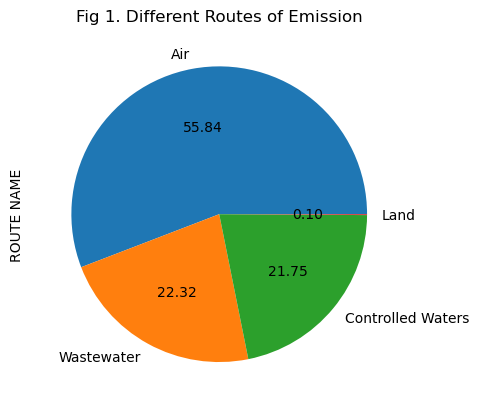

In [12]:
#We can also represent the above output visually:

graph_1 = df['ROUTE NAME'].value_counts().plot(kind='pie', title= "Fig 1. Different Routes of Emission", autopct='%.2f')

#55.84% of substances in our data are air pollutants

<AxesSubplot:xlabel='ROUTE NAME', ylabel='count'>

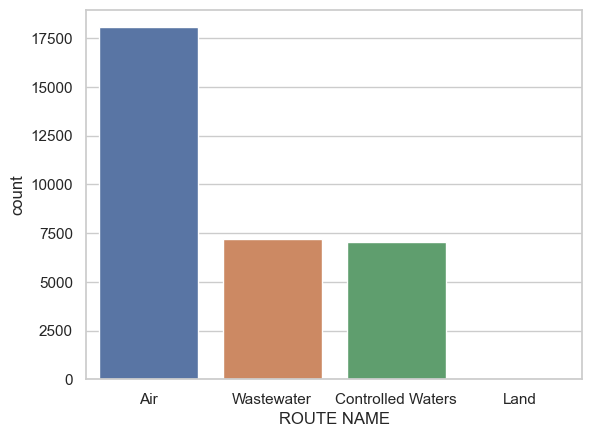

In [13]:
#We can also generate customised countplot graphs using seaborn library
sns.set_theme(style="whitegrid")
sns.countplot(x=df["ROUTE NAME"])

In [14]:
#Let's explore another column in the dataframe

df['REGULATED INDUSTRY SECTOR'].value_counts()

Landfill                 9286
Water Industry           4712
Agriculture              3121
Chemicals                2482
Hazardous Waste          2398
EfW                      2376
Food & Drink             1998
Combustion               1435
Metals                   1342
Biowaste Treatment        703
Paper and textiles        543
Metals Recycling          509
Refineries & Fuel         480
Cement and Minerals       427
Nuclear                   165
Oil and Gas               117
Non-Hazardous & Inert     112
No Far Sector              98
combustion                 30
Name: REGULATED INDUSTRY SECTOR, dtype: int64

We can see above that there are two categories named 'combustion' with only difference in case of letter "c". Lets clean this data. 

Data Cleaning and Manipulation

There are certain steps to take to prepare our data for analysis.

In [15]:
#(ref: https://datatofish.com/replace-values-pandas-dataframe/)

#find and replace
df['REGULATED INDUSTRY SECTOR'] = df['REGULATED INDUSTRY SECTOR'].replace(['combustion'], 'Combustion')
df['REGULATED INDUSTRY SECTOR'].value_counts()

Landfill                 9286
Water Industry           4712
Agriculture              3121
Chemicals                2482
Hazardous Waste          2398
EfW                      2376
Food & Drink             1998
Combustion               1465
Metals                   1342
Biowaste Treatment        703
Paper and textiles        543
Metals Recycling          509
Refineries & Fuel         480
Cement and Minerals       427
Nuclear                   165
Oil and Gas               117
Non-Hazardous & Inert     112
No Far Sector              98
Name: REGULATED INDUSTRY SECTOR, dtype: int64

[Text(0.5, 0, 'Industry'), Text(0, 0.5, 'count')]

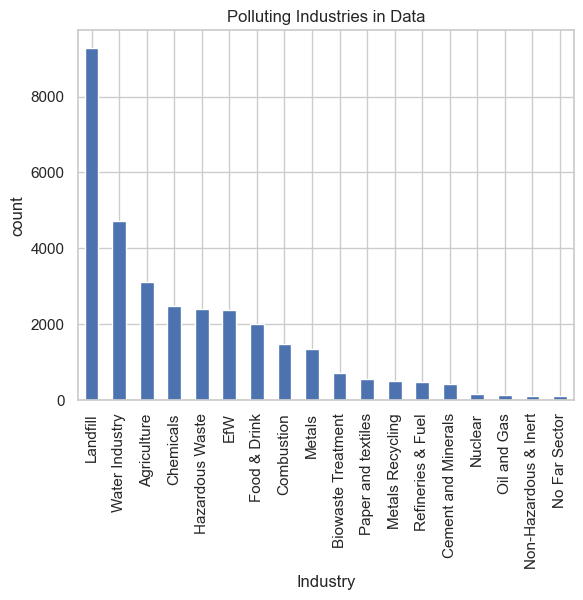

In [16]:
#We can also visualise the above output

graph_2 = df['REGULATED INDUSTRY SECTOR'].value_counts().plot(kind='bar', title="Polluting Industries in Data")
graph_2.set(xlabel="Industry", ylabel="count")

# ref - https://stackoverflow.com/questions/21487329/add-x-and-y-labels-to-a-pandas-plot

Adding and removing columns are also some ways of data manipulation that can help make analysis easier

In [17]:
#Dropping unwanted columns

df.drop(['AUTHORISATION ID / PERMIT ID', 'SITE ADDRESS', 'SITE POSTCODE','EA AREA NAME','REGULATED INDUSTRY SUB SECTOR'], axis = 1, inplace= True)


In [18]:
#lets check the no. of columns

df.shape

(32334, 9)

In [19]:
#adding a column
df['ABOVE_THRESHOLD'] = np.where(df['QUANTITY RELEASED (kg)'].notna(), [True], [False])


In [20]:

#view data frame without the dropped columns and with the added column
df.head()

,ACTIVITY DESCRIPTION,OPERATOR NAME,EASTING,NORTHING,ROUTE NAME,SUBSTANCE NAME,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg),REGULATED INDUSTRY SECTOR,ABOVE_THRESHOLD
0,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Air,Sulphur oxides (SO2 and SO3) as SO2,1.000000e+05,NaN,Paper and textiles,False
1,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Wastewater,Cypermethrin,5.000000e-03,0.02,Paper and textiles,True
2,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Wastewater,Total organic carbon (TOC),5.000000e+04,NaN,Paper and textiles,False
3,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Air,Carbon dioxide,1.000000e+07,NaN,Paper and textiles,False
4,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Air,Carbon monoxide,1.000000e+05,NaN,Paper and textiles,False


In [21]:
#checking for missing values
df.isnull().sum()

ACTIVITY DESCRIPTION          4887
OPERATOR NAME                    0
EASTING                        181
NORTHING                       181
ROUTE NAME                       0
SUBSTANCE NAME                   0
REPORTING THRESHOLD (kg)         0
QUANTITY RELEASED (kg)       23994
REGULATED INDUSTRY SECTOR        0
ABOVE_THRESHOLD                  0
dtype: int64

We can see that there is a large number of missing values, specially in the quantity released column.
On properly examining the data, we would know that the reason the data is missing is because it is not required to be reported if it is below the reporting threshold - i.e., those values simply do not exist. In this case, we may not be able to accurately impute missing values.

Therefore our strategy to handle missing data is: 
- When dealing with the Easting and Northing columns, we will simply remove missing values as these are very few
- When dealing with the "Quantity Released (kg)" column, we will classify the data as below or above reporting threshold and perform relavent analysis based on these


DATA ANALYSIS AND VISUALISATIONS

Some relevent questions we may want to answer through data analysis are:

1. How widespread is the pollution across UK? (Geographic visualisation)
2. Which industries pollute most above and below threshold?
3. Which industries have highest quantity of emissions?
4. Which industrial activities have highest quantity of emissions?
5. Which substances have highest quantity of emissions?
6. Which industries pollute much higher than the reporting threshold?
7. What is the ratio of quantity of emissions to the reporting threshold?

We will also use additional statistical analysis such as correlation and chi square test of independence to exlore relationships between variables.

Geographically mapping the entire data set


In [22]:
# filter out missing values
geo_df = df [df['NORTHING'].notna()]
geo_df.isnull().sum()

ACTIVITY DESCRIPTION          4887
OPERATOR NAME                    0
EASTING                          0
NORTHING                         0
ROUTE NAME                       0
SUBSTANCE NAME                   0
REPORTING THRESHOLD (kg)         0
QUANTITY RELEASED (kg)       23818
REGULATED INDUSTRY SECTOR        0
ABOVE_THRESHOLD                  0
dtype: int64

In [23]:
# Geographically mapping the entire data set

#converting easting and northing into latitudes and longitudes

#Step 1: convert easting and northing columns from data frame into lists
est = geo_df["EASTING"].tolist()
ntg = geo_df["NORTHING"].tolist()

#Step 2: Use the convert_latlon function from convertbng library
latlon = convert_lonlat(est, ntg)

#storing them as columns in the data frame
geo_df['LAT'],geo_df['LON'] = latlon[0],latlon[1]

In [24]:
#reading shape file
gdf = gpd.read_file('geo_shape/GBR_adm2.shp')

In [25]:
#specifiying the cordinate refernce system
crs = {'init':'epsg:4326'}

#converting latitudes and lognitudes into points to plot on map
geometry = [Point(xy) for xy in zip(geo_df["LAT"],geo_df["LON"])]

#creating the geo data frame
geo_df = gpd.GeoDataFrame(geo_df[['LAT','LON']],crs=crs,geometry=geometry) 

In [26]:
#lets view the geo data frame

geo_df.head()

,LAT,LON,geometry
0,-1.639446,53.686187,POINT (-1.63945 53.68619)
1,-1.639446,53.686187,POINT (-1.63945 53.68619)
2,-1.639446,53.686187,POINT (-1.63945 53.68619)
3,-1.639446,53.686187,POINT (-1.63945 53.68619)
4,-1.639446,53.686187,POINT (-1.63945 53.68619)


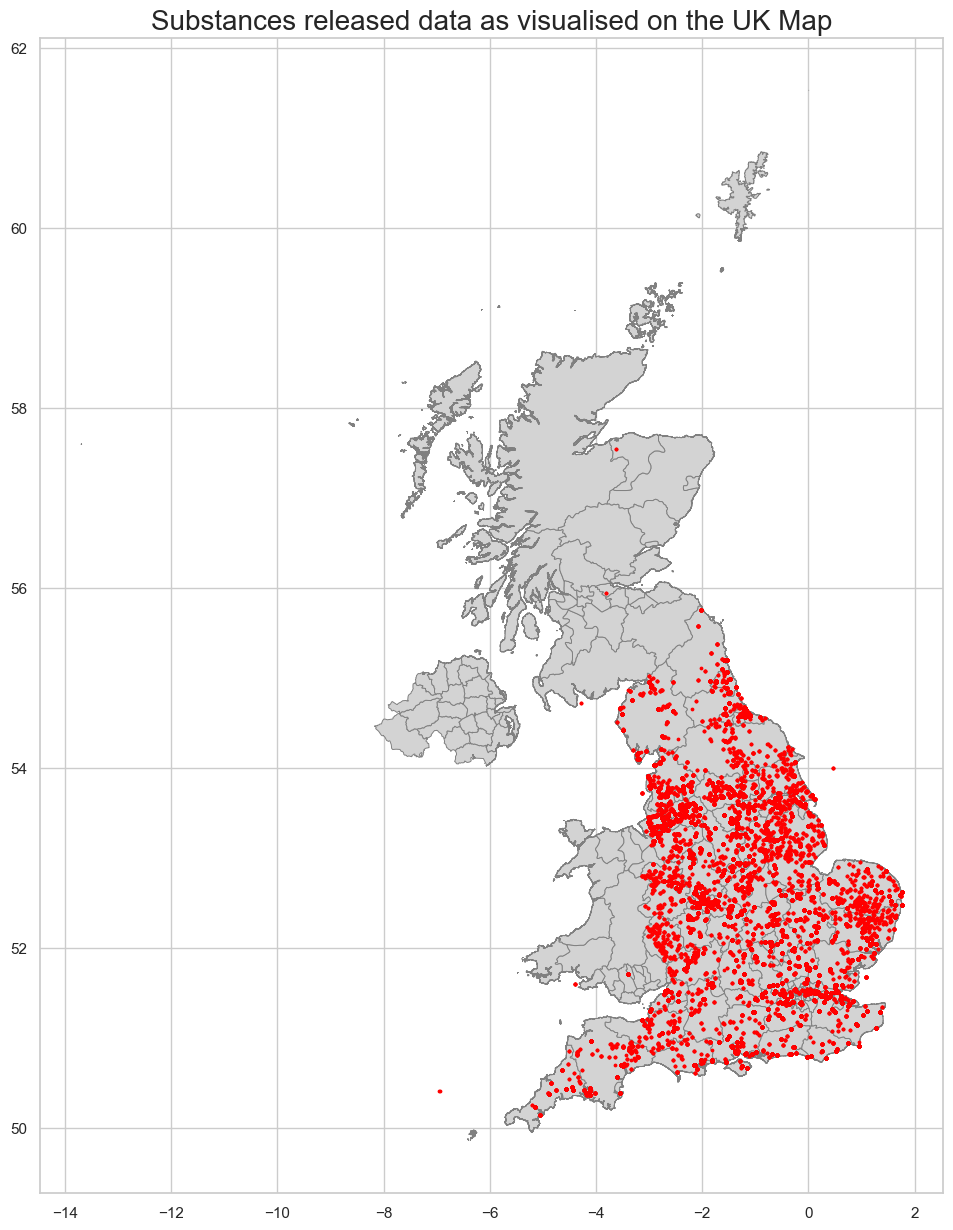

In [27]:
#plotting
fig, ax = plt.subplots(figsize=(15,15))

#plot UK map
gdf.plot(ax=ax, color='lightgray', edgecolor='grey', linewidth=0.7) 

#plot the data points
geo_df.plot(ax=ax, marker='o', color='red', markersize=3 )  #specifiying features
plt.title('Substances released data as visualised on the UK Map',fontsize=20)  #title of graph
plt.show()  #display plot


Geographic visualisation of substances released data

We can modify the above visualisation to plot points relative to the quantity of emissions:

In [28]:
#first lets filter the data to include only those rows that have substance emissions
Above_Threshold_df = df[df['QUANTITY RELEASED (kg)'].notna()]

In [29]:
#view first 5 rows to confirm that NA rows have been removed
Above_Threshold_df.head()

,ACTIVITY DESCRIPTION,OPERATOR NAME,EASTING,NORTHING,ROUTE NAME,SUBSTANCE NAME,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg),REGULATED INDUSTRY SECTOR,ABOVE_THRESHOLD
1,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Wastewater,Cypermethrin,0.0050,0.020,Paper and textiles,True
6,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Wastewater,Dieldrin,0.0005,0.002,Paper and textiles,True
15,CARBON DISULPHIDE OR AMMONIA; AMMONIA RELEASE ...,Angus Fire Limited,366600.0,469100.0,Air,Ammonia,1000.0000,2440.000,Chemicals,True
21,TREATMENT AND PROCESSING (OTHER THAN PACKAGING...,Mondelez UK Confectionery Production Limited,404840.0,279910.0,Air,Hydrofluorocarbons (HFCs),100.0000,1039.000,Food & Drink,True
22,"INTENSIVE FARMING; > 40,000 POULTRY",Watkins; Watkins,367380.0,231840.0,Air,Ammonia,1000.0000,2550.000,Agriculture,True


In [30]:
#filter out missing easting and northing values

geo2_df = Above_Threshold_df [Above_Threshold_df ['NORTHING'].notna()]

#check to see that there are no nul values now
geo2_df.isnull().sum()

ACTIVITY DESCRIPTION         2820
OPERATOR NAME                   0
EASTING                         0
NORTHING                        0
ROUTE NAME                      0
SUBSTANCE NAME                  0
REPORTING THRESHOLD (kg)        0
QUANTITY RELEASED (kg)          0
REGULATED INDUSTRY SECTOR       0
ABOVE_THRESHOLD                 0
dtype: int64

Before proceeding to geographic data analysis, lets first perform some basic statistics with our data now that we have removed null values from most columns.
Earlier we used the describe() function to get some of the baisc descriptive statistics. We can also use other functions to get minimum, maximum, mean values etc., of an individual column.

In [31]:
#finding min and max value of reporting threshold and emissions

#convert data frame columns into list 
list_1 = df["REPORTING THRESHOLD (kg)"].tolist()
list_2 = Above_Threshold_df["QUANTITY RELEASED (kg)"].tolist()

#use of min and max functions and string concactation
print("The maximum value of reporting threshold is " + str(min(list_1)))
print("The minimim value of reporting threshold is " + str(max(list_1)))
print("The maximum value of quantity released is " + str(max(list_2)))
print("The minimum value of quantity released is " + str(min(list_2)))

The maximum value of reporting threshold is 0.0
The minimim value of reporting threshold is 100000000.0
The maximum value of quantity released is 14769265000.0
The minimum value of quantity released is 0.0


In [32]:
#mean
print(Above_Threshold_df['QUANTITY RELEASED (kg)'].mean())
print(Above_Threshold_df['REPORTING THRESHOLD (kg)'].mean())

15387041.154022
572960.7691674582


In [33]:
#we can also write our own code to find the mean of a given column

#convert column from data frame to list

quant_list = Above_Threshold_df['QUANTITY RELEASED (kg)'].tolist()
report_thresh_list = Above_Threshold_df['REPORTING THRESHOLD (kg)'].tolist()

#get mean by diving the sum of the list by the no. of values in the list
mean_quant = sum(quant_list)/len(quant_list)
print(mean_quant)

mean_report_thresh = sum(report_thresh_list) / len(report_thresh_list)
print(mean_report_thresh)

15387041.15402202
572960.7691674599


In [34]:
#median
print(Above_Threshold_df['QUANTITY RELEASED (kg)'].median())
print(Above_Threshold_df['REPORTING THRESHOLD (kg)'].median())

3032.0
1000.0


In [35]:
#we can also write our own code to find the median of a given column

median_quant = sorted(quant_list) [int(len(quant_list)/2)]
print(median_quant)


median_report_thresh = sorted(report_thresh_list) [int(len(report_thresh_list)/2)]
print(median_report_thresh)

3033.0
1000.0


Now, lets continue with geographic data analysis.

In [36]:
#convert data to lat and long
est = geo2_df["EASTING"].tolist()
ntg= geo2_df["NORTHING"].tolist()
latlon= convert_lonlat(est, ntg)

#storing them as columns in the data frame
geo2_df['LAT'],geo2_df['LON'] = latlon[0],latlon[1]


In [37]:
#lets view the data frame with the new columns
geo2_df.head()

,ACTIVITY DESCRIPTION,OPERATOR NAME,EASTING,NORTHING,ROUTE NAME,SUBSTANCE NAME,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg),REGULATED INDUSTRY SECTOR,ABOVE_THRESHOLD,LAT,LON
1,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Wastewater,Cypermethrin,0.0050,0.020,Paper and textiles,True,-1.639446,53.686187
6,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Wastewater,Dieldrin,0.0005,0.002,Paper and textiles,True,-1.639446,53.686187
15,CARBON DISULPHIDE OR AMMONIA; AMMONIA RELEASE ...,Angus Fire Limited,366600.0,469100.0,Air,Ammonia,1000.0000,2440.000,Chemicals,True,-2.512452,54.116688
21,TREATMENT AND PROCESSING (OTHER THAN PACKAGING...,Mondelez UK Confectionery Production Limited,404840.0,279910.0,Air,Hydrofluorocarbons (HFCs),100.0000,1039.000,Food & Drink,True,-1.930257,52.417179
22,"INTENSIVE FARMING; > 40,000 POULTRY",Watkins; Watkins,367380.0,231840.0,Air,Ammonia,1000.0000,2550.000,Agriculture,True,-2.476388,51.984061


In [38]:
#converting latitudes and longitudes to points for plotting
geometry = [Point(xy) for xy in zip(geo2_df["LAT"],geo2_df["LON"])]

#specifying the cordinate reference system
crs = {'init':'epsg:4326'} 

#getting the geo data frame
geo2_df = gpd.GeoDataFrame(geo2_df[['QUANTITY RELEASED (kg)','LAT','LON']],crs=crs,geometry=geometry) 


In [39]:
#scale quantity values with minmax scaler 
scaler = MinMaxScaler() 

#scaling to standardise the data points and avoid large numbers
geo2_df['QUANTITY RELEASED (kg)'] = scaler.fit_transform(np.array(geo2_df['QUANTITY RELEASED (kg)']).reshape(-1, 1))

#multiplying by 1000 to clearly visualise on the map
geo2_df['QUANTITY RELEASED (kg)'] = geo2_df['QUANTITY RELEASED (kg)'] * 1000

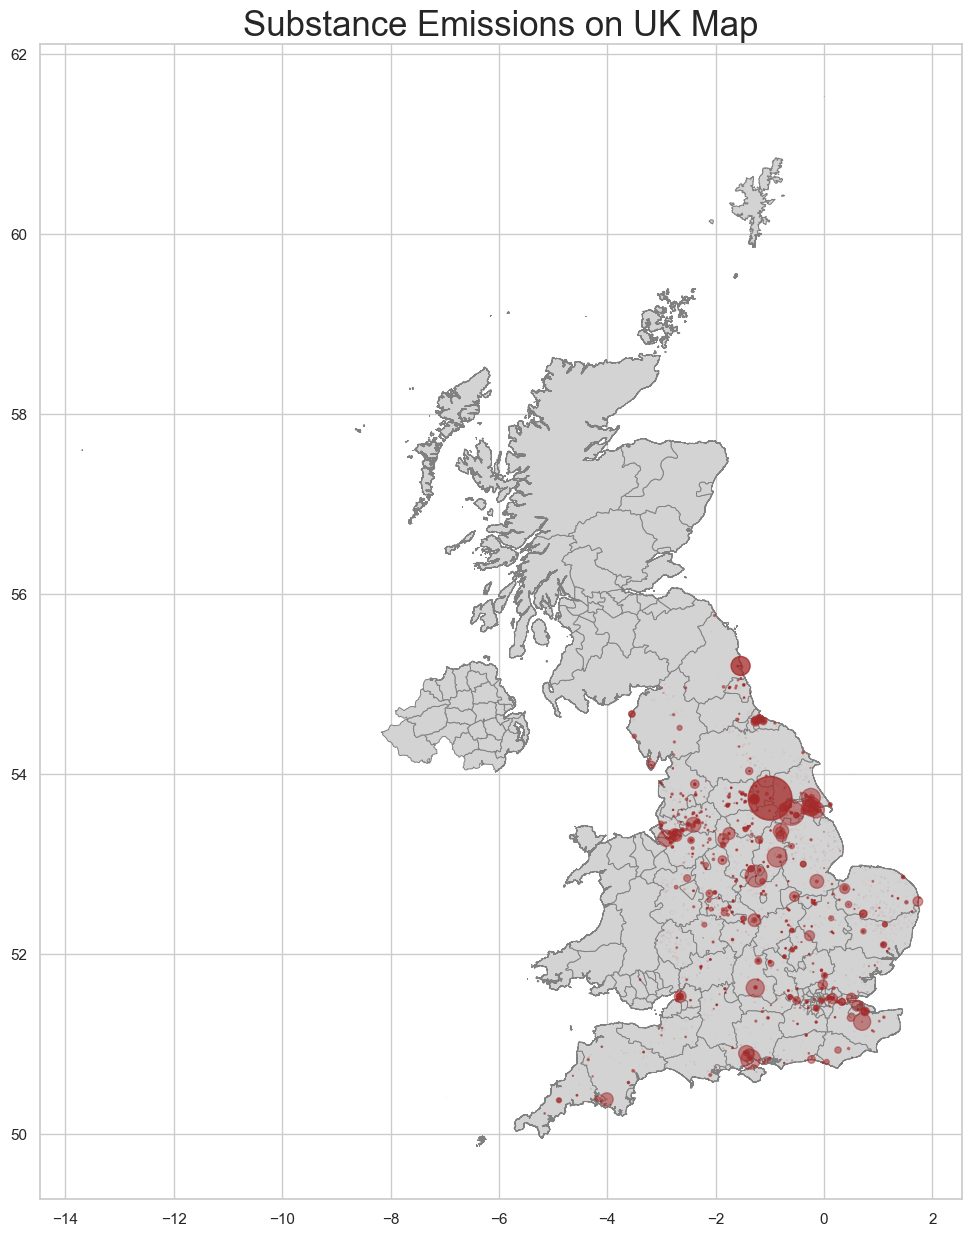

In [40]:
#plotting

fig, ax = plt.subplots(figsize=(15,15))

#plot UK map
gdf.plot(ax=ax, color='lightgray', edgecolor='grey', linewidth=0.7) 

#plot the quantity scaled values on map to identify locations according to quantity of substance released
geo2_df.plot(ax=ax, color='brown', markersize='QUANTITY RELEASED (kg)',
alpha=0.5, categorical=True, legend=True )

plt.title('Substance Emissions on UK Map',fontsize=25)
plt.show()

Next, it would be relavent to look at which industries most commonly pollute above and below reporting threshold. We can easily do this using the group by and value counts function:

In [41]:
df['REGULATED INDUSTRY SECTOR'].groupby(df['ABOVE_THRESHOLD']).value_counts()  #using groupby and value_counts function

ABOVE_THRESHOLD  REGULATED INDUSTRY SECTOR
False            Landfill                     8488
                 Hazardous Waste              2336
                 Chemicals                    2072
                 Water Industry               1898
                 EfW                          1820
                 Food & Drink                 1743
                 Combustion                   1105
                 Metals                       1086
                 Agriculture                   959
                 Biowaste Treatment            579
                 Metals Recycling              502
                 Paper and textiles            431
                 Refineries & Fuel             292
                 Cement and Minerals           228
                 Nuclear                       157
                 Non-Hazardous & Inert         111
                 Oil and Gas                    94
                 No Far Sector                  93
True             Water Industry        

We can see that in our data, landfill, hazardous waste and chemical industries are the top polluting industries (in terms of number, not quantity) whose emission level is above reporting threshold.

Most number of Water, Agriculture and Landfill industries maintain emission levels below reporting threshold.

In [42]:
#Which industries, activities and substances have highest quantity of emissions?


highest_emissions = Above_Threshold_df.sort_values("QUANTITY RELEASED (kg)", ascending= False)
highest_emissions.head(10)

# Combustion industries and activities have the largest amount of emissions and CO2 is the pollutant emitted in largest quantities. 

,ACTIVITY DESCRIPTION,OPERATOR NAME,EASTING,NORTHING,ROUTE NAME,SUBSTANCE NAME,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg),REGULATED INDUSTRY SECTOR,ABOVE_THRESHOLD
6394,COMBUSTION; ANY FUEL =>50MW,Drax Power Limited,466410.0,426480.0,Air,Carbon dioxide,10000000.0,1.476926e+10,Combustion,True
6420,COMBUSTION; ANY FUEL =>50MW,Drax Power Limited,466410.0,426480.0,Air,Carbon Dioxide From Qualifying Renewable Fuel ...,0.0,1.426190e+10,Combustion,True
13549,COMBUSTION; ANY FUEL =>50MW,British Steel Limited,492720.0,408890.0,Air,Carbon dioxide,10000000.0,4.679901e+09,Metals,True
3661,COMBUSTION; ANY FUEL =>50MW,Uniper UK Limited,450300.0,330100.0,Air,Carbon dioxide,10000000.0,3.630000e+09,Combustion,True
23896,COMBUSTION; ANY FUEL =>50MW,RWE Generation UK Plc,476140.0,354010.0,Air,Carbon dioxide,10000000.0,3.011979e+09,Combustion,True
6320,REFINING MINERAL OILS,ESSO Petroleum Company Limited,445550.0,103660.0,Air,Carbon dioxide,10000000.0,2.953574e+09,Refineries & Fuel,True
16097,COMBUSTION; ANY FUEL =>50MW,VPI Immingham LLP,516680.0,417160.0,Air,Carbon dioxide,10000000.0,2.742865e+09,Combustion,True
29580,COMBUSTION; ANY FUEL =>50MW,Lynemouth Power Limited,429440.0,589700.0,Air,Carbon Dioxide From Qualifying Renewable Fuel ...,0.0,2.740000e+09,Combustion,True
29593,COMBUSTION; ANY FUEL =>50MW,Lynemouth Power Limited,429440.0,589700.0,Air,Carbon dioxide,10000000.0,2.740000e+09,Combustion,True
7133,COMBUSTION; ANY FUEL =>50MW,Saltend Cogeneration Company Limited,515990.0,428040.0,Air,Carbon dioxide,10000000.0,2.729296e+09,Combustion,True


Feature Engineering

One way to understand how much the industries are actually polluting is to look at the quantity released relative to the reporting threshold - i.e. calculating their ratio. Since reporting thresholds are likely set based on how toxic the pollutant is, this may give us a more relavent understanding of our data.

In [43]:
Above_Threshold_df['RATIO'] = Above_Threshold_df["QUANTITY RELEASED (kg)"]/ Above_Threshold_df["REPORTING THRESHOLD (kg)"]

In [44]:
#view data with new ratio column
Above_Threshold_df.head()

,ACTIVITY DESCRIPTION,OPERATOR NAME,EASTING,NORTHING,ROUTE NAME,SUBSTANCE NAME,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg),REGULATED INDUSTRY SECTOR,ABOVE_THRESHOLD,RATIO
1,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Wastewater,Cypermethrin,0.0050,0.020,Paper and textiles,True,4.00
6,"COATING, PRINTING AND TEXTILES; PRE-TREATING B...",Westex (Carpets) Limited,423910.0,421140.0,Wastewater,Dieldrin,0.0005,0.002,Paper and textiles,True,4.00
15,CARBON DISULPHIDE OR AMMONIA; AMMONIA RELEASE ...,Angus Fire Limited,366600.0,469100.0,Air,Ammonia,1000.0000,2440.000,Chemicals,True,2.44
21,TREATMENT AND PROCESSING (OTHER THAN PACKAGING...,Mondelez UK Confectionery Production Limited,404840.0,279910.0,Air,Hydrofluorocarbons (HFCs),100.0000,1039.000,Food & Drink,True,10.39
22,"INTENSIVE FARMING; > 40,000 POULTRY",Watkins; Watkins,367380.0,231840.0,Air,Ammonia,1000.0000,2550.000,Agriculture,True,2.55


In [45]:
highest_ratio_emissions = Above_Threshold_df.sort_values("RATIO", ascending= False)

highest_ratio_emissions.head()

#These operators and industries emmit infinitely many times more than their reporting threshold

,ACTIVITY DESCRIPTION,OPERATOR NAME,EASTING,NORTHING,ROUTE NAME,SUBSTANCE NAME,REPORTING THRESHOLD (kg),QUANTITY RELEASED (kg),REGULATED INDUSTRY SECTOR,ABOVE_THRESHOLD,RATIO
9536,"WASTE LANDFILLING; >10 T/D WITH CAPACITY >25,0...",FCC Waste Services (UK) Limited,468780.0,224620.0,Air,Carbon Dioxide From Qualifying Renewable Fuel ...,0.0,54800000.0,Landfill,True,inf
28119,"WASTE LANDFILLING; >10 T/D WITH CAPACITY >25,0...",Lincwaste Limited,493050.0,367630.0,Air,Carbon Dioxide From Qualifying Renewable Fuel ...,0.0,9790000.0,Landfill,True,inf
21386,"WASTE LANDFILLING; >10 T/D WITH CAPACITY >25,0...",Enovert North Limited,404700.0,302600.0,Air,Carbon Dioxide From Qualifying Renewable Fuel ...,0.0,10300000.0,Landfill,True,inf
18264,PRODUCING CEMENT CLINKER IN ROTARY KILNS WITH ...,Castle Cement Limited,374830.0,443640.0,Air,Carbon Dioxide From Qualifying Renewable Fuel ...,0.0,43260000.0,Cement and Minerals,True,inf
3058,THE INCINERATION OF NON-HAZARDOUS WASTE IN AN ...,Enfinium K3 CHP Operations Limited,591810.0,166400.0,Air,Carbon Dioxide From Qualifying Renewable Fuel ...,0.0,306000000.0,EfW,True,inf


In [46]:
lowest_ratio_emissions = Above_Threshold_df.sort_values("RATIO", ascending= True)

#Instead of viewing the entire data frame as above, we can selectively view the column values of our choice

low_list = lowest_ratio_emissions["REGULATED INDUSTRY SECTOR"].tolist()
print(low_list[:10])

#The below output shows some of the industries that have lowest ratio of quantity emitted to reporting threshold 

['Biowaste Treatment', 'Biowaste Treatment', 'Biowaste Treatment', 'Biowaste Treatment', 'Metals', 'Metals', 'Biowaste Treatment', 'Chemicals', 'Chemicals', 'Chemicals']


In [47]:
#if we wanted to see only the unique values, we can convert our list to a set

new_list = low_list[:10]
industries_set = set(new_list)

print(industries_set)

# the below output shows some of the industries that have lowest ratio of quantity emitted to reporting threshold

{'Chemicals', 'Biowaste Treatment', 'Metals'}


Additional analyses

In [48]:
#finding correlations (between continuous varibles)

corr_matrix = Above_Threshold_df.corr(method='pearson', numeric_only = True)
print(corr_matrix)

                           EASTING  NORTHING  REPORTING THRESHOLD (kg)  \
EASTING                   1.000000 -0.163641                 -0.018440   
NORTHING                 -0.163641  1.000000                  0.037519   
REPORTING THRESHOLD (kg) -0.018440  0.037519                  1.000000   
QUANTITY RELEASED (kg)    0.005241  0.023368                  0.192269   
ABOVE_THRESHOLD                NaN       NaN                       NaN   
RATIO                    -0.006147  0.008825                 -0.007560   

                          QUANTITY RELEASED (kg)  ABOVE_THRESHOLD     RATIO  
EASTING                                 0.005241              NaN -0.006147  
NORTHING                                0.023368              NaN  0.008825  
REPORTING THRESHOLD (kg)                0.192269              NaN -0.007560  
QUANTITY RELEASED (kg)                  1.000000              NaN  0.067457  
ABOVE_THRESHOLD                              NaN              NaN       NaN  
RATIO        

Most of the above correlations are weak, which make sense considering magnitude of geographic cordinates are not something that would logically correlate with magnitude of emissions.

Let us create a scatterplot to visualise the relationship between reporting threshold and quantity released (variables that have a logical possibility of correlating).

<AxesSubplot:xlabel='QUANTITY RELEASED (kg)', ylabel='REPORTING THRESHOLD (kg)'>

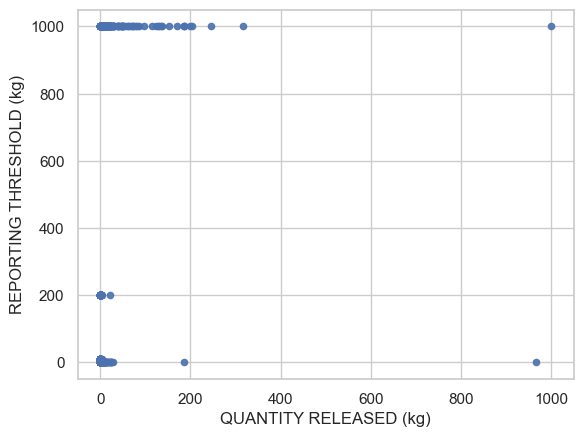

In [49]:
#Scatterplot

#scaling to better visulise the relationship

scaler = MinMaxScaler() 

Above_Threshold_df['QUANTITY RELEASED (kg)'] = scaler.fit_transform(np.array(Above_Threshold_df['QUANTITY RELEASED (kg)']).reshape(-1, 1))

Above_Threshold_df['QUANTITY RELEASED (kg)'] = Above_Threshold_df['QUANTITY RELEASED (kg)'] * 1000

Above_Threshold_df['REPORTING THRESHOLD (kg)'] = scaler.fit_transform(np.array(Above_Threshold_df['REPORTING THRESHOLD (kg)']).reshape(-1, 1))

Above_Threshold_df['REPORTING THRESHOLD (kg)'] = Above_Threshold_df['REPORTING THRESHOLD (kg)'] * 1000

Above_Threshold_df.plot(kind = 'scatter', x = 'QUANTITY RELEASED (kg)', y ='REPORTING THRESHOLD (kg)', alpha = 0.9)

In [50]:
# Exploring relationship between Route of polution and industry sector (two categorical variables)

crosstab = pd.crosstab(df["ROUTE NAME"], df["REGULATED INDUSTRY SECTOR"], margins = True)
print(crosstab)

REGULATED INDUSTRY SECTOR  Agriculture  Biowaste Treatment  \
ROUTE NAME                                                   
Air                               3120                 436   
Controlled Waters                    1                  64   
Land                                 0                  26   
Wastewater                           0                 177   
All                               3121                 703   

REGULATED INDUSTRY SECTOR  Cement and Minerals  Chemicals  Combustion   EfW  \
ROUTE NAME                                                                    
Air                                        367       1303        1125  2145   
Controlled Waters                           48        531         265    68   
Land                                         0          0           0     0   
Wastewater                                  12        648          75   163   
All                                        427       2482        1465  2376   

REGULATED I

In [51]:
#Getting chi square statistic and expected counts
stats.chi2_contingency(crosstab)

(21278.564341347395,
 0.0,
 72,
 array([[1.74264038e+03, 3.92526814e+02, 2.38419558e+02, 1.38584858e+03,
         8.17996845e+02, 1.32666246e+03, 1.11560252e+03, 1.33894637e+03,
         5.18492744e+03, 7.49318612e+02, 2.84205047e+02, 5.47192429e+01,
         6.25362776e+01, 9.21293375e+01, 6.53280757e+01, 3.03189274e+02,
         2.68012618e+02, 2.63099054e+03, 1.80540000e+04],
        [6.78755242e+02, 1.52888477e+02, 9.28639822e+01, 5.39785489e+02,
         3.18608276e+02, 5.16732603e+02, 4.34525144e+02, 5.21517165e+02,
         2.01951976e+03, 2.91858230e+02, 1.10697346e+02, 2.13130451e+01,
         2.43577658e+01, 3.58842086e+01, 2.54451661e+01, 1.18091668e+02,
         1.04390425e+02, 1.02476600e+03, 7.03200000e+03],
        [2.99223727e+00, 6.73996412e-01, 4.09383312e-01, 2.37960042e+00,
         1.40455867e+00, 2.27797365e+00, 1.91556875e+00, 2.29906600e+00,
         8.90288860e+00, 1.28663327e+00, 4.88000247e-01, 9.39568256e-02,
         1.07379229e-01, 1.58192615e-01, 1.121729

The 1st value in the optput is the chi square statistic, the second is statistical significance, third - degree of freedom, and forth is the expected counts.

While results indicate a significant relationship between the two categorical variables, on close observation we notice that over 20% of expected counts are below 5, making chi square analysis unreliable.